In [2]:
import os, urllib
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from PIL import Image
from tensorflow.keras.models import model_from_json
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras import applications
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# Pre-processing steps


In [54]:
# !unzip charts.zip

In [5]:
df = pd.read_csv('charts/train_val.csv')
print(df['image_index'])

df['chart'] = pd.Series([str(x) + '.png' for x in range(len(df.index))])
df.to_csv('charts/train.csv')

0        0
1        1
2        2
3        3
4        4
      ... 
995    995
996    996
997    997
998    998
999    999
Name: image_index, Length: 1000, dtype: int64


In [7]:
traindf = pd.read_csv('charts/train.csv')
traindf['code'] = traindf['type'].astype('category').cat.codes
traindf.to_csv('charts/train.csv')
traindf.head()

,Unnamed: 0,image_index,type,chart,code
0,0,0,vbar_categorical,0.png,4
1,1,1,vbar_categorical,1.png,4
2,2,2,vbar_categorical,2.png,4
3,3,3,vbar_categorical,3.png,4
4,4,4,vbar_categorical,4.png,4


In [8]:
import cv2
img= cv2.imread('charts/train_val/0.png')
print(img.shape)

(128, 128, 3)


### Common Section
#### This section is common to both task 2 and task 3

In [14]:
def printHistory(history, epochs):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    t = f.suptitle("VGG-19", fontsize=12)
    f.subplots_adjust(top=0.85, wspace=0.3)

    epoch_list = list(range(1,epochs+1))
    ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
    ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_xticks(np.arange(0, epochs+1, 5))
    ax1.set_ylabel('Accuracy Value')
    ax1.set_xlabel('Epoch')
    ax1.set_title('Accuracy')
    l1 = ax1.legend(loc="best")

    ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
    ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
    ax2.set_xticks(np.arange(0, epochs+1, 5))
    ax2.set_ylabel('Loss Value')
    ax2.set_xlabel('Epoch')
    ax2.set_title('Loss')
    l2 = ax2.legend(loc="best")

In [15]:
def trainModelDF(images, epochs, cross_validation_folds, model_type):
    print("Train Model")
     
    datagen_train = ImageDataGenerator(rescale=1./255.,
                                       rotation_range=10,
                                       width_shift_range=0.1, 
                                       height_shift_range=0.1,
                                       shear_range = 0.2,
                                       zoom_range = 0.2,
                                       horizontal_flip = True)

    datagen_valid = ImageDataGenerator(rescale=1./255)
            
    print("Cross validation")
    kfold = StratifiedKFold(n_splits=cross_validation_folds, shuffle=True)
    cvscores = []
    iteration = 1
    
    t = images.code
    
    for train_index, test_index in kfold.split(np.zeros(len(t)), t):

        print("Iteration = ", iteration)

        iteration = iteration + 1

        train = images.loc[train_index]
        test = images.loc[test_index]

        if model_type == 'CNN':
          model = createCNN()
        elif model_type == 'VGG19':
          model = createModel()
        # model = createModel()
        
        train_generator = datagen_train.flow_from_dataframe(dataframe=train,
                                                  directory="charts/train_val",
                                                  x_col="chart",
                                                  y_col="type",
                                                  batch_size=32,
                                                  seed=42,
                                                  shuffle=True,
                                                  class_mode="categorical",
                                                  target_size=(128, 128));

        valid_generator=datagen_valid.flow_from_dataframe(dataframe=test,
                                                  directory="charts/train_val",
                                                  x_col="chart",
                                                  y_col="type",
                                                  batch_size=32,
                                                  seed=42,
                                                  shuffle=False,
                                                  class_mode="categorical",
                                                  target_size=(128, 128));
        
        STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
        STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

        #Trains the model on data generated batch-by-batch by a Python generator
        history = model.fit_generator(generator=train_generator,\
                            validation_data = valid_generator, \
                            steps_per_epoch=STEP_SIZE_TRAIN, \
                            validation_steps=STEP_SIZE_VALID, \
                            epochs=epochs, \
                            verbose=1)
                
        scores = model.evaluate_generator(generator=valid_generator, steps=STEP_SIZE_VALID)
        print("Accuarcy %s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
        cvscores.append(scores[1] * 100)
        
        printHistory(history, epochs)

    accuracy = np.mean(cvscores);
    std = np.std(cvscores);
    print("Accuracy: %.2f%% (+/- %.2f%%)" % (accuracy, std))
    return accuracy, std, model

In [22]:
def trainFinalModel(images, epochs, model_type):
    print("Train Model")

    datagen_train = ImageDataGenerator(rescale=1./255.,
                                       rotation_range=10,
                                       width_shift_range=0.1, 
                                       height_shift_range=0.1,
                                       shear_range = 0.2,
                                       zoom_range = 0.2,
                                       horizontal_flip = True)
    if model_type == 'CNN':
      model = createCNN()
    elif model_type == 'VGG19':
      model = createModel()

    # model = createModel()
    print(model)
    
    train_generator = datagen_train.flow_from_dataframe(dataframe=images,
                                                  directory="charts/train_val",
                                                  x_col="chart",
                                                  y_col="type",
                                                  batch_size=32,
                                                  seed=42,
                                                  shuffle=True,
                                                  class_mode="categorical",
                                                  target_size=(128, 128));

    STEP_SIZE_TRAIN=train_generator.n // train_generator.batch_size
    
    #Trains the model on data generated batch-by-batch by a Python generator
    model.fit_generator(generator = train_generator,\
                        steps_per_epoch = STEP_SIZE_TRAIN, \
                        epochs = epochs, \
                        verbose = 1)

    print(model)
    return model

# Task 3


In [21]:
def createModel():
    vgg_model = applications.VGG19(weights = "imagenet", include_top=False, input_shape = (128, 128, 3))

    for layer in vgg_model.layers[:-5]:
        layer.trainable=False
        
    input = Input(shape=(128, 128, 3), name = 'image_input')
    output_vgg19_conv = vgg_model(input)

    x = BatchNormalization()(output_vgg19_conv)
    x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
    x = Dropout(0.2)(x)

    x = Flatten()(x)
    x = Dense(4096, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    x = Dense(5, activation='softmax')(x)

    model = Model(inputs=input, outputs=x)

    model.summary()

    model.compile(loss = "categorical_crossentropy",
              optimizer = optimizers.Adadelta(lr = 1.0, rho = 0.95, epsilon = 1e-08, decay = 0.0),
              metrics = ['accuracy'])
    
    return model

#### Training

Train Model
Cross validation
Iteration =  1
80150528/80134624 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_input (InputLayer)    [(None, 128, 128, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 batch_normalization (BatchN  (None, 4, 4, 512)        2048      
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 2, 2, 512)        0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 2, 2, 512)         0         
                  

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adadelta.py:74: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adadelta, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/30
25/25 [==============================] - 21s 279ms/step - loss: 0.2865 - accuracy: 0.9025 - val_loss: 0.2696 - val_accuracy: 0.8698
Epoch 2/30
25/25 [==============================] - 4s 170ms/step - loss: 0.0730 - accuracy: 0.9700 - val_loss: 0.2149 - val_accuracy: 0.9375
Epoch 3/30
25/25 [==============================] - 7s 267ms/step - loss: 0.0090 - accuracy: 0.9962 - val_loss: 0.0436 - val_accuracy: 0.9844
Epoch 4/30
25/25 [==============================] - 4s 170ms/step - loss: 0.0166 - accuracy: 0.9950 - val_loss: 0.0049 - val_accuracy: 1.0000
Epoch 5/30
25/25 [==============================] - 5s 193ms/step - loss: 0.0183 - accuracy: 0.9962 - val_loss: 0.0892 - val_accuracy: 0.9688
Epoch 6/30
25/25 [==============================] - 7s 298ms/step - loss: 0.0334 - accuracy: 0.9937 - val_loss: 0.3446 - val_accuracy: 0.9010
Epoch 7/30
25/25 [==============================] - 5s 207ms/step - loss: 0.0099 - accuracy: 0.9962 - val_loss: 0.0279 - val_accuracy: 0.9896
Epoch

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.


Accuarcy accuracy: 100.00%
Iteration =  2
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_input (InputLayer)    [(None, 128, 128, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 batch_normalization_4 (Batc  (None, 4, 4, 512)        2048      
 hNormalization)                                                 
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 2, 2, 512)        0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 2, 2, 512)         0         
                                                                 
 flatten_1 (Flatt

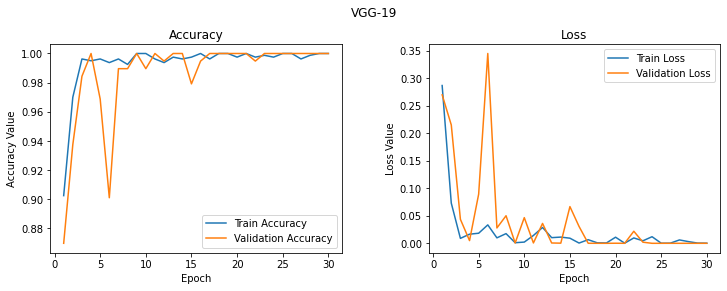

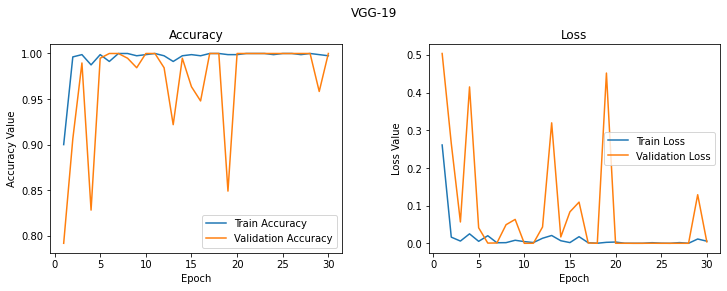

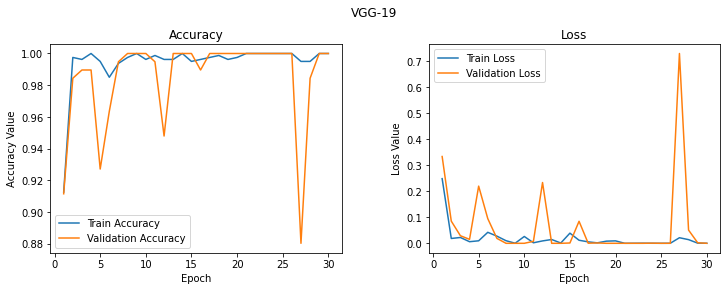

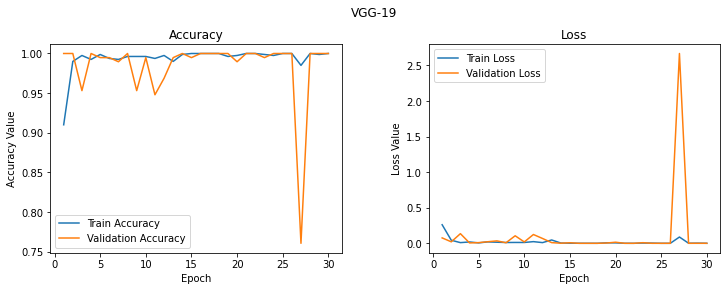

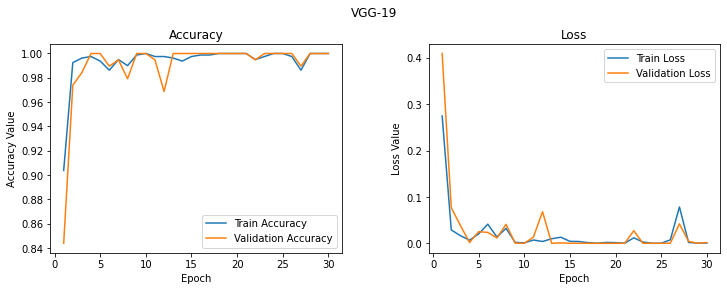

In [16]:
accuracy, std, model = trainModelDF(
    traindf,
    cross_validation_folds = 5,
    epochs = 30,
    model_type = 'VGG19'
)

In [18]:
model = trainFinalModel(
    traindf,
    epochs = 30,
    model_type = 'VGG19'
)

Train Model
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_input (InputLayer)    [(None, 128, 128, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 batch_normalization_20 (Bat  (None, 4, 4, 512)        2048      
 chNormalization)                                                
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 2, 2, 512)        0         
 2D)                                                             
                                                                 
 dropout_20 (Dropout)        (None, 2, 2, 512)         0         
                                                                 
 flatten_5 (Flatten)         (None, 2048)      

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adadelta.py:74: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adadelta, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/30
31/31 [==============================] - 11s 273ms/step - loss: 0.2213 - accuracy: 0.9236
Epoch 2/30
31/31 [==============================] - 7s 222ms/step - loss: 0.0286 - accuracy: 0.9938
Epoch 3/30
31/31 [==============================] - 5s 154ms/step - loss: 0.0102 - accuracy: 0.9969
Epoch 4/30
31/31 [==============================] - 5s 154ms/step - loss: 0.0240 - accuracy: 0.9917
Epoch 5/30
31/31 [==============================] - 5s 154ms/step - loss: 0.0188 - accuracy: 0.9917
Epoch 6/30
31/31 [==============================] - 6s 177ms/step - loss: 0.0058 - accuracy: 0.9979
Epoch 7/30
31/31 [==============================] - 5s 157ms/step - loss: 0.0099 - accuracy: 0.9979
Epoch 8/30
31/31 [==============================] - 5s 157ms/step - loss: 0.0038 - accuracy: 1.0000
Epoch 9/30
31/31 [==============================] - 6s 186ms/step - loss: 0.0787 - accuracy: 0.9824
Epoch 10/30
31/31 [==============================] - 7s 229ms/step - loss: 0.0293 - accuracy: 0.991

In [19]:
model

In [23]:
# linked to google drive, created model folder and added model files ..
from google.colab import drive
drive.mount('/content/gDrive')

Mounted at /content/gDrive


#### Save Models

In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("/content/gDrive/MyDrive/model/model.json", "w") as json_file:
    json_file.write(model_json)
    
# serialize weights to HDF5
model.save_weights("/content/gDrive/MyDrive/model/model.h5")
print("Saved model to disk")

Saved model to disk


#### Testing

In [26]:
!ls charts/test > a.txt
txt = pd.read_csv('a.txt', header=None)
txt.columns = ['chart']
txt.to_csv(r'charts/test.csv', index = None)

In [27]:
traindf = pd.read_csv('charts/train.csv')

train_datagen = ImageDataGenerator(rescale=1./255.)  
train_generator = train_datagen.flow_from_dataframe(dataframe=traindf,
                                              directory="charts/train_val",
                                              x_col="chart",
                                              y_col="type",
                                              batch_size=32,
                                              seed=42,
                                              shuffle=True,
                                              class_mode="categorical",
                                              target_size=(128, 128));

print(train_generator)

Found 1000 validated image filenames belonging to 5 classes.


In [29]:
testdf = pd.read_csv('charts/test.csv')

test_datagen = ImageDataGenerator(rescale=1./255.)

test_generator = test_datagen.flow_from_dataframe(
    dataframe = testdf,
    directory = "charts/test",
    x_col = "chart",
    y_col = None,
    batch_size = 1,
    seed = 42,
    shuffle = False,
    class_mode = None,
    target_size = (128, 128))

Found 50 validated image filenames.


In [55]:
json_file = open('gDrive/MyDrive/model/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("gDrive/MyDrive/model/model.h5")
print("Loaded model from disk")

Loaded model from disk


In [56]:
test_generator.reset()
STEP_SIZE_TEST=test_generator.n // test_generator.batch_size

pred = loaded_model.predict(test_generator,
                            steps=STEP_SIZE_TEST,
                            verbose=1)

50/50 [==============================] - 1s 7ms/step


In [57]:
predicted_class_indices = np.argmax(pred, axis=1)

In [58]:
labels = (train_generator.class_indices)
print(labels)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

{'dot_line': 0, 'hbar_categorical': 1, 'line': 2, 'pie': 3, 'vbar_categorical': 4}


In [59]:
filenames = test_generator.filenames

results = pd.DataFrame({"chart": filenames, "type": predictions})
results.to_csv("results/predictionsVGG19.csv", index = False)

#### Plotting predictions

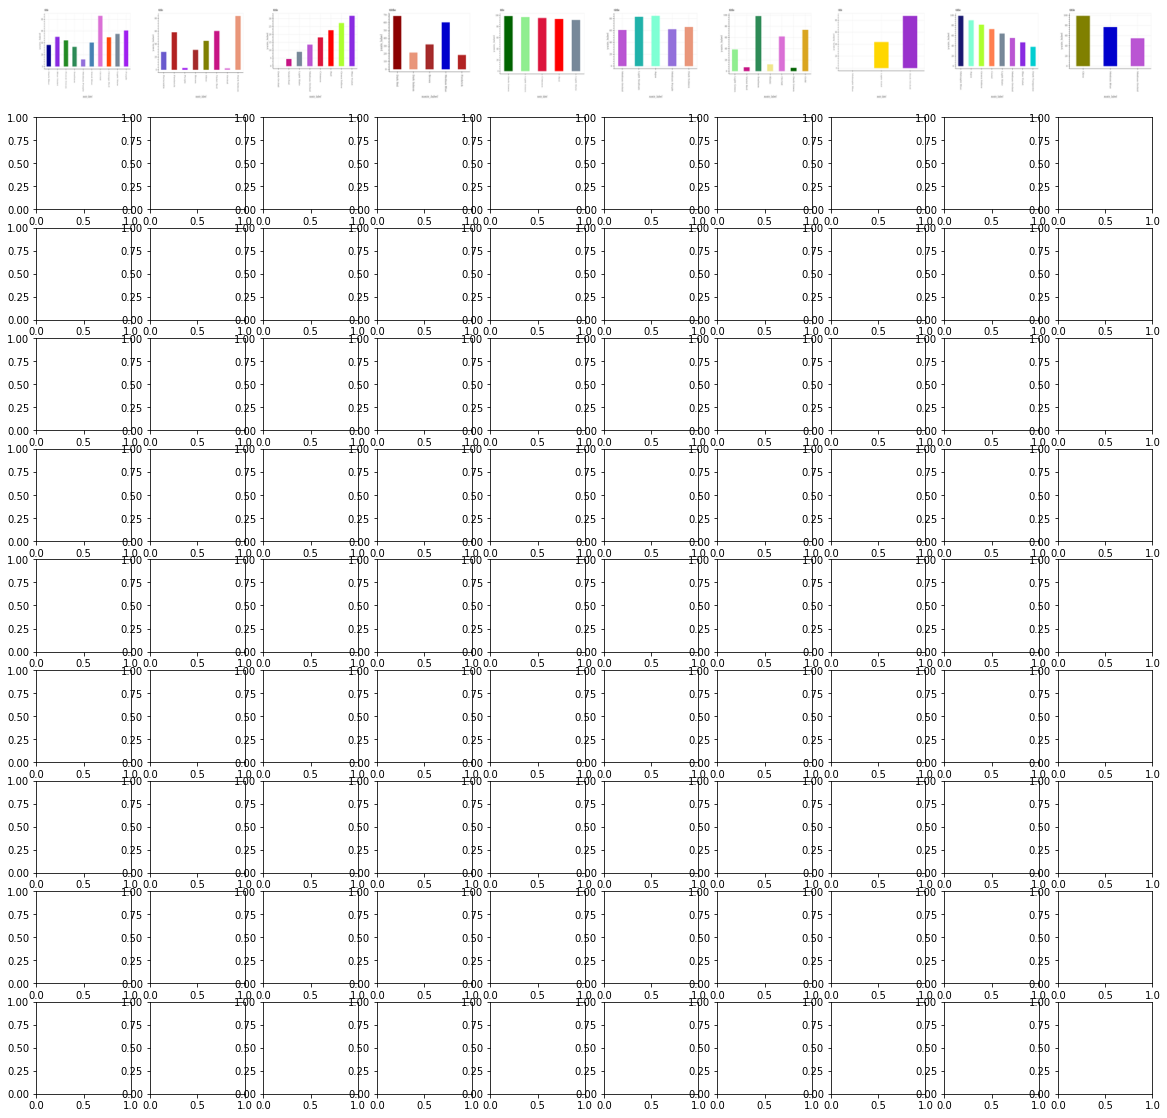

In [62]:
vplots = results.loc[results['type'] == 'vbar_categorical']

f, ax = plt.subplots(10, 10, figsize = (20, 20))

for index in range(100):
    ax[index // 10, index % 10].imshow(mpimg.imread("charts/test/" + vplots.iloc[index]['chart']))
    ax[index // 10, index % 10].axis('off')
    ax[index // 10, index % 10].set_aspect('equal')
    
plt.show()

# TASK 2

In [ ]:
def createCNN():
  model = tf.keras.models.Sequential()

  input_size = (128, 128)
  model.add(tf.keras.layers.Convolution2D(32, 3, 3, input_shape = (*input_size, 3), activation = 'relu'))
  model.add(tf.keras.layers.MaxPooling2D(pool_size = (2, 2)))

  model.add(tf.keras.layers.Convolution2D(32, 3, 3, activation = 'relu'))
  model.add(tf.keras.layers.MaxPooling2D(pool_size = (2, 2)))

  model.add(tf.keras.layers.Flatten())

  model.add(tf.keras.layers.Dense(units = 64, activation = 'relu'))
  model.add(tf.keras.layers.Dropout(0.5))
  model.add(tf.keras.layers.Dense(units = 5, activation = 'softmax'))
 
  model.compile(loss = "categorical_crossentropy",
            optimizer = optimizers.Adadelta(learning_rate = 1.0, rho = 0.95, epsilon = 1e-08, decay = 0.0),
            metrics = ['accuracy'])
  return model

#### Training

Train Model
Cross validation
Iteration =  1
Found 800 validated image filenames belonging to 5 classes.
Found 200 validated image filenames belonging to 5 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/30
25/25 [==============================] - 15s 136ms/step - loss: 1.6091 - accuracy: 0.2362 - val_loss: 1.5790 - val_accuracy: 0.4167
Epoch 2/30
25/25 [==============================] - 3s 133ms/step - loss: 1.5662 - accuracy: 0.2962 - val_loss: 1.5059 - val_accuracy: 0.3490
Epoch 3/30
25/25 [==============================] - 3s 138ms/step - loss: 1.4729 - accuracy: 0.3762 - val_loss: 1.3477 - val_accuracy: 0.5000
Epoch 4/30
25/25 [==============================] - 3s 132ms/step - loss: 1.2931 - accuracy: 0.4300 - val_loss: 1.1217 - val_accuracy: 0.5260
Epoch 5/30
25/25 [==============================] - 3s 135ms/step - loss: 1.1055 - accuracy: 0.4988 - val_loss: 0.9308 - val_accuracy: 0.6146
Epoch 6/30
25/25 [==============================] - 4s 142ms/step - loss: 0.9976 - accuracy: 0.5263 - val_loss: 0.8474 - val_accuracy: 0.6198
Epoch 7/30
25/25 [==============================] - 4s 141ms/step - loss: 0.9499 - accuracy: 0.5475 - val_loss: 0.7874 - val_accuracy: 0.6302
Epoch

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.


Accuarcy accuracy: 82.81%
Iteration =  2
Found 800 validated image filenames belonging to 5 classes.
Found 200 validated image filenames belonging to 5 classes.
Epoch 1/30
25/25 [==============================] - 4s 147ms/step - loss: 1.6300 - accuracy: 0.2113 - val_loss: 1.5924 - val_accuracy: 0.3385
Epoch 2/30
25/25 [==============================] - 3s 135ms/step - loss: 1.5916 - accuracy: 0.2500 - val_loss: 1.5649 - val_accuracy: 0.2344
Epoch 3/30
25/25 [==============================] - 3s 136ms/step - loss: 1.5478 - accuracy: 0.3275 - val_loss: 1.4875 - val_accuracy: 0.5260
Epoch 4/30
25/25 [==============================] - 3s 133ms/step - loss: 1.4340 - accuracy: 0.4250 - val_loss: 1.3135 - val_accuracy: 0.5104
Epoch 5/30
25/25 [==============================] - 3s 135ms/step - loss: 1.2215 - accuracy: 0.4900 - val_loss: 1.1030 - val_accuracy: 0.5677
Epoch 6/30
25/25 [==============================] - 6s 260ms/step - loss: 1.0812 - accuracy: 0.5425 - val_loss: 0.8997 - val_accu

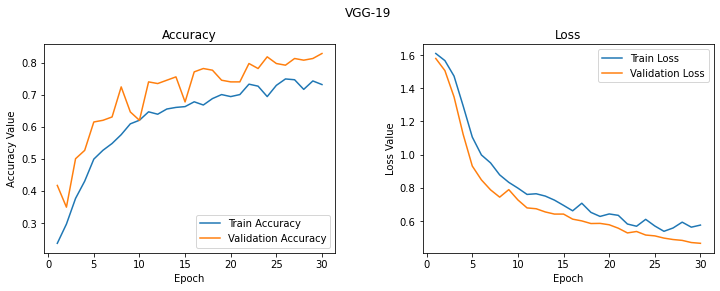

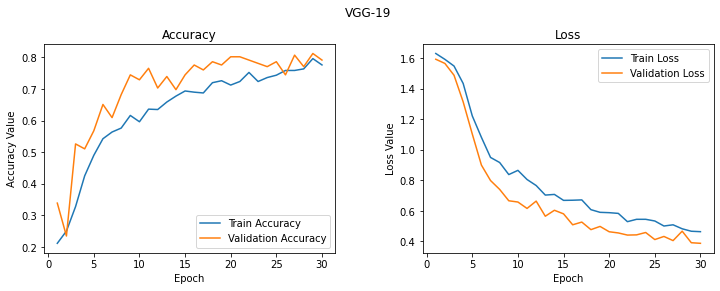

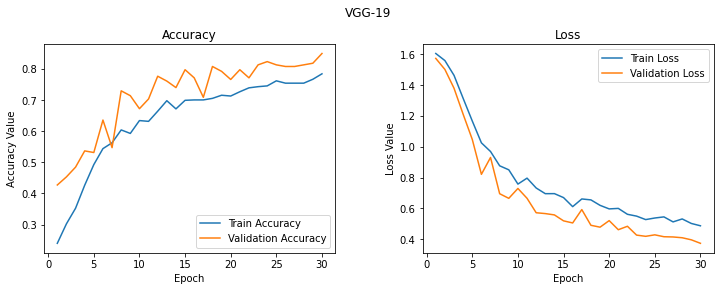

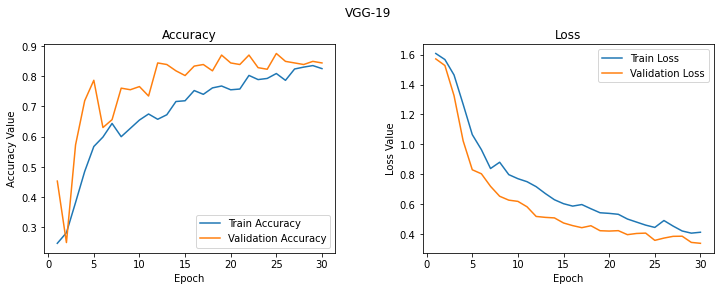

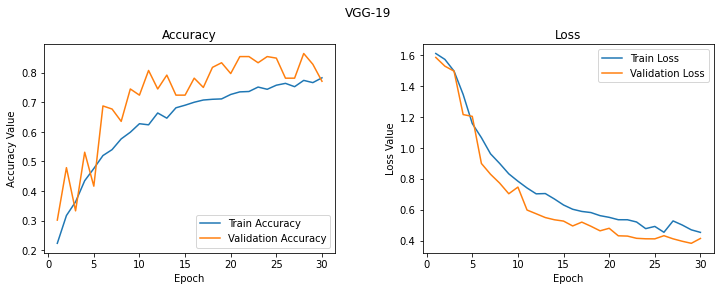

In [ ]:
accuracy, std, model = trainModelDF(
    traindf,
    cross_validation_folds = 5,
    epochs = 30,
    model_type = 'CNN'
)

In [ ]:
modelCNN = trainFinalModel(
    traindf,
    epochs = 30,
    model_type = 'CNN'
)

Train Model
Found 1000 validated image filenames belonging to 5 classes.
Epoch 1/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


31/31 [==============================] - 4s 128ms/step - loss: 1.5973 - accuracy: 0.2417
Epoch 2/30
31/31 [==============================] - 4s 122ms/step - loss: 1.5136 - accuracy: 0.3295
Epoch 3/30
31/31 [==============================] - 4s 121ms/step - loss: 1.3889 - accuracy: 0.3998
Epoch 4/30
31/31 [==============================] - 4s 122ms/step - loss: 1.2394 - accuracy: 0.4452
Epoch 5/30
31/31 [==============================] - 4s 123ms/step - loss: 1.0501 - accuracy: 0.5372
Epoch 6/30
31/31 [==============================] - 4s 121ms/step - loss: 0.9300 - accuracy: 0.5826
Epoch 7/30
31/31 [==============================] - 4s 124ms/step - loss: 0.8919 - accuracy: 0.5868
Epoch 8/30
31/31 [==============================] - 4s 122ms/step - loss: 0.8184 - accuracy: 0.6446
Epoch 9/30
31/31 [==============================] - 4s 123ms/step - loss: 0.7980 - accuracy: 0.6302
Epoch 10/30
31/31 [==============================] - 4s 123ms/step - loss: 0.7339 - accuracy: 0.6591
Epoch 11/3

#### Save Model

In [ ]:
# serialize model to JSON
model_json = modelCNN.to_json()
with open("/content/gDrive/MyDrive/model/modelCNN.json", "w") as json_file:
    json_file.write(model_json)
    
# serialize weights to HDF5
model.save_weights("/content/gDrive/MyDrive/model/modelCNN.h5")
print("Saved model to disk")

Saved model to disk


#### Testing

In [63]:
json_file = open('gDrive/MyDrive/model/modelCNN.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("gDrive/MyDrive/model/modelCNN.h5")
print("Loaded model from disk")

Loaded model from disk


In [64]:
test_generator.reset()
STEP_SIZE_TEST=test_generator.n // test_generator.batch_size

pred = loaded_model.predict(test_generator,
                            steps=STEP_SIZE_TEST,
                            verbose=1)

50/50 [==============================] - 0s 3ms/step


In [65]:
predicted_class_indices = np.argmax(pred, axis=1)

In [66]:
labels = (train_generator.class_indices)
print(labels)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

{'dot_line': 0, 'hbar_categorical': 1, 'line': 2, 'pie': 3, 'vbar_categorical': 4}


In [67]:
filenames = test_generator.filenames

results = pd.DataFrame({"chart": filenames, "type": predictions})
results.to_csv("results/predictionsCNN.csv", index = False)

#### Plotting Predictions

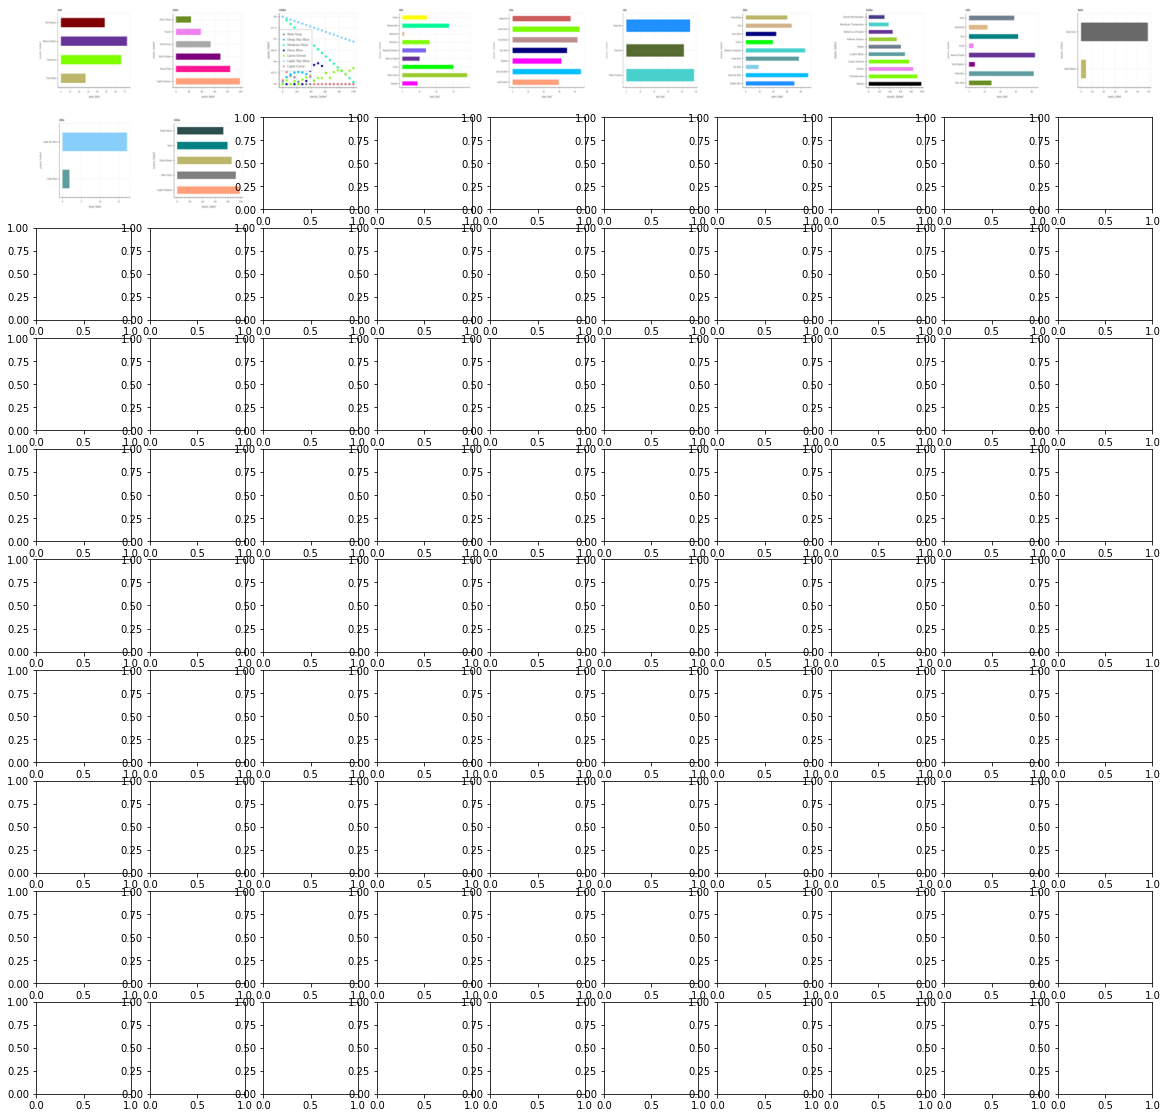

In [70]:
vplots = results.loc[results['type'] == 'hbar_categorical']

f, ax = plt.subplots(10, 10, figsize = (20, 20))

for index in range(100):
    ax[index // 10, index % 10].imshow(mpimg.imread("charts/test/" + vplots.iloc[index]['chart']))
    ax[index // 10, index % 10].axis('off')
    ax[index // 10, index % 10].set_aspect('equal')
    
plt.show()